# Weather Forecasting Project - ESIEE PARIS - E4 AIC 
### By The Tai VUONG
### Under the monitoring of Charif EL JAZOULI


The Hybrid Energy Forecasting and Trading Competition, organized by IEEE, focuses on the development and implementation of predictive models for various types of energy production. For this project, the objective was to predict solar energy generation using historical data and advanced machine learning techniques. Our  objective was to forecast the 'solar_MW' feature, leveraging a model trained on data spanning from 2020 to 2023.

## Librairies


In [37]:
# !python --version
import os
import pandas as pd
import xarray as xr
import numpy as np


from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, f_classif


import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pickle as pkl
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

In [38]:
def KNN(df):
    """
    Function that imputates the NaN values.
    
    :param Dataframe df: a pandas dataset with nan values
    :returns: an imputated dataset
    """
    from sklearn.impute import KNNImputer
    impute = KNNImputer(missing_values=np.nan,n_neighbors=3).fit_transform(df)
    impute = pd.DataFrame(impute, columns=df.columns)
    return impute

In [39]:
# Evaluate models
def evaluate_model(y_test, y_pred, model_name):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred,squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"{model_name} - Mean Squared Error: {mse:.4f}, R^2 Score: {r2:.4f} Root Mean Squared Error: {rmse:.4f}, Mean Absolute Percentage Error: {mape:.4f}")

# Data cleanning
We will open the different files for the project. Here we need to create a dataset with all the features that we are required, .nc and .csv. The loaded data are from 2020 to 2023.

This file contains the Cloud Cover, Solar Downward Radiation and Temperature features.

In [40]:
dwd_rain = xr.open_dataset("dwd_icon_eu_demand_20200920_20231027.nc")

In [41]:
dwd_rain_features1 = dwd_rain["RelativeHumidity"].mean(dim="point").to_dataframe().reset_index()
dwd_rain_features2 = dwd_rain["TotalPrecipitation"].mean(dim="point").to_dataframe().reset_index()

dwd_rain_features = dwd_rain_features1.merge(dwd_rain_features2,how="outer",on=["ref_datetime","valid_datetime"])
dwd_rain_features["ref_datetime"]=dwd_rain_features["ref_datetime"].dt.tz_localize("UTC")
dwd_rain_features["valid_datetime"] = dwd_rain_features["ref_datetime"] + pd.TimedeltaIndex(dwd_rain_features["valid_datetime"],unit="hours")


In [42]:
# Visualization of the data
dwd_rain

<xarray.Dataset>
Dimensions:             (ref_datetime: 4467, valid_datetime: 93, point: 7)
Coordinates:
    latitude            (point) float64 ...
    longitude           (point) float64 ...
  * point               (point) int64 0 1 2 3 4 5 6
  * ref_datetime        (ref_datetime) datetime64[ns] 2020-09-20 ... 2023-10-27
  * valid_datetime      (valid_datetime) int64 0 1 2 3 4 ... 108 111 114 117 120
Data variables:
    RelativeHumidity    (ref_datetime, valid_datetime, point) float32 85.22 ....
    Temperature         (ref_datetime, valid_datetime, point) float32 ...
    TotalPrecipitation  (ref_datetime, valid_datetime, point) float64 nan ......
    WindDirection       (ref_datetime, valid_datetime, point) float32 ...
    WindSpeed           (ref_datetime, valid_datetime, point) float32 ...

In [43]:
# Load and preprocess data for 2020-2023
dwd_solar = xr.open_dataset("dwd_icon_eu_pes10_20200920_20231027.nc")

In [44]:
# Visualization of the data
dwd_solar

<xarray.Dataset>
Dimensions:                 (ref_datetime: 4467, valid_datetime: 93, point: 20)
Coordinates:
    latitude                (point) float64 ...
    longitude               (point) float64 ...
  * point                   (point) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
  * ref_datetime            (ref_datetime) datetime64[ns] 2020-09-20 ... 2023...
  * valid_datetime          (valid_datetime) int64 0 1 2 3 4 ... 111 114 117 120
Data variables:
    CloudCover              (ref_datetime, valid_datetime, point) float32 ...
    SolarDownwardRadiation  (ref_datetime, valid_datetime, point) float64 ...
    Temperature             (ref_datetime, valid_datetime, point) float32 ...

We can see that there are 3 variables that seems to be interresting: 
    <br> -CloudCover
    <br> -SolarDownwardRadiation
    <br> -Temperature

In [45]:
dwd_solar_features1 = dwd_solar["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()
dwd_solar_features2 = dwd_solar["CloudCover"].mean(dim="point").to_dataframe().reset_index()
dwd_solar_features3 = dwd_solar["Temperature"].mean(dim="point").to_dataframe().reset_index()

solar_features_merge = dwd_solar_features1.merge(dwd_solar_features2,how="outer",on=["ref_datetime","valid_datetime"])
dwd_solar_features = solar_features_merge.merge(dwd_solar_features3,how="outer",on=["ref_datetime","valid_datetime"])

dwd_solar_features["ref_datetime"]=dwd_solar_features["ref_datetime"].dt.tz_localize("UTC")
dwd_solar_features["valid_datetime"] = dwd_solar_features["ref_datetime"] + pd.TimedeltaIndex(dwd_solar_features["valid_datetime"],unit="hours")

In [46]:
# Visualization of the data
dwd_solar_features

,ref_datetime,valid_datetime,SolarDownwardRadiation,CloudCover,Temperature
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,0.000000,0.450405,13.646173
1,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,0.000000,0.494018,13.670843
2,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,0.000000,0.546410,13.793360
3,2020-09-20 00:00:00+00:00,2020-09-20 03:00:00+00:00,0.000000,0.627071,13.907354
4,2020-09-20 00:00:00+00:00,2020-09-20 04:00:00+00:00,0.000000,0.681062,14.022113
...,...,...,...,...,...
415426,2023-10-27 00:00:00+00:00,2023-10-31 12:00:00+00:00,180.746119,0.810468,12.455963
415427,2023-10-27 00:00:00+00:00,2023-10-31 15:00:00+00:00,23.697193,0.459340,12.856787
415428,2023-10-27 00:00:00+00:00,2023-10-31 18:00:00+00:00,0.976647,0.069910,10.006506
415429,2023-10-27 00:00:00+00:00,2023-10-31 21:00:00+00:00,0.932845,0.652018,8.682965


Here's the csv containning the Solar energy.

In [47]:
data_energy = pd.read_csv("Energy_Data_20200920_20231027.csv")
data_energy

,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price
0,2020-09-20T00:00:00Z,20.06,0.0,2108.489754,2206.064655,996.284,2.50,0.0,32.17
1,2020-09-20T00:30:00Z,19.77,0.0,2108.489754,2206.064655,957.576,15.00,0.0,32.17
2,2020-09-20T01:00:00Z,28.68,0.0,2108.489754,2206.064655,941.044,47.95,0.0,32.00
3,2020-09-20T01:30:00Z,28.97,0.0,2108.489754,2206.064655,964.366,29.13,0.0,32.00
4,2020-09-20T02:00:00Z,28.19,0.0,2108.489754,2206.064655,918.432,28.95,0.0,31.99
...,...,...,...,...,...,...,...,...,...
54379,2023-10-27T21:30:00Z,NaN,0.0,2331.383994,2487.180474,275.444,129.00,0.0,82.47
54380,2023-10-27T22:00:00Z,NaN,0.0,2331.383994,2487.180474,132.522,129.00,0.0,64.31
54381,2023-10-27T22:30:00Z,NaN,0.0,2331.383994,2487.180474,64.226,133.00,0.0,64.31
54382,2023-10-27T23:00:00Z,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68


In [48]:
data_energy.dtypes

dtm                             object
MIP                            float64
Solar_MW                       float64
Solar_capacity_mwp             float64
Solar_installedcapacity_mwp    float64
Wind_MW                        float64
SS_Price                       float64
boa_MWh                        float64
DA_Price                       float64
dtype: object

In [49]:
data_energy.describe()

,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price
count,54063.000000,54309.000000,54384.000000,54384.000000,54281.000000,54384.000000,54281.000000,54384.000000
mean,129.760255,237.428856,2180.185332,2305.999500,562.881904,130.830663,-1.678418,133.842703
std,96.418365,382.797675,82.631288,97.989387,436.031903,132.215372,22.928449,102.125494
min,-77.290000,0.000000,2108.431714,2206.064655,0.000000,-185.330000,-599.500000,-51.520000
25%,67.330000,0.000000,2118.198318,2229.567230,132.604000,60.000000,0.000000,69.775000
50%,104.790000,0.423976,2139.253276,2264.538513,492.844000,105.000000,0.000000,105.510000
75%,168.990000,354.798564,2267.405793,2407.928381,1052.840000,176.455000,0.000000,170.782500
max,1983.660000,1792.289600,2337.607243,2487.180474,1192.744000,4037.800000,0.000000,2196.220000


Now we have to merge the csv with the NC file. 

In [50]:
data_dwdMerged = dwd_rain_features.merge(dwd_solar_features,how="outer",on=["ref_datetime","valid_datetime"])


In [51]:
# Visualization of the data
data_dwdMerged

,ref_datetime,valid_datetime,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,90.793594,NaN,0.000000,0.450405,13.646173
1,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,91.974014,0.000000,0.000000,0.494018,13.670843
2,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,92.541222,0.000000,0.000000,0.546410,13.793360
3,2020-09-20 00:00:00+00:00,2020-09-20 03:00:00+00:00,93.603523,0.000000,0.000000,0.627071,13.907354
4,2020-09-20 00:00:00+00:00,2020-09-20 04:00:00+00:00,94.086113,0.000000,0.000000,0.681062,14.022113
...,...,...,...,...,...,...,...
415426,2023-10-27 00:00:00+00:00,2023-10-31 12:00:00+00:00,78.098076,0.013765,180.746119,0.810468,12.455963
415427,2023-10-27 00:00:00+00:00,2023-10-31 15:00:00+00:00,76.115318,0.000744,23.697193,0.459340,12.856787
415428,2023-10-27 00:00:00+00:00,2023-10-31 18:00:00+00:00,90.014153,0.065848,0.976647,0.069910,10.006506
415429,2023-10-27 00:00:00+00:00,2023-10-31 21:00:00+00:00,93.445007,0.287574,0.932845,0.652018,8.682965


In [52]:
data_energy['dtm'] = pd.to_datetime(data_energy['dtm'], utc=True)

modelling_table = data_dwdMerged
modelling_table = modelling_table.set_index("valid_datetime").groupby("ref_datetime").resample("30min").ffill()
modelling_table = modelling_table.drop(columns="ref_datetime",axis=1).reset_index()
modelling_table = data_dwdMerged.merge(data_energy,how="inner",left_on="valid_datetime",right_on="dtm")
modelling_table = modelling_table[modelling_table["valid_datetime"] - modelling_table["ref_datetime"] < np.timedelta64(50,"h")]

In [53]:
modelling_table

,ref_datetime,valid_datetime,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,90.793594,NaN,0.000000,0.450405,13.646173,2020-09-20 00:00:00+00:00,20.06,0.0,2108.489754,2206.064655,996.284,2.50,0.0,32.17
1,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,91.974014,0.000000,0.000000,0.494018,13.670843,2020-09-20 01:00:00+00:00,28.68,0.0,2108.489754,2206.064655,941.044,47.95,0.0,32.00
2,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,92.541222,0.000000,0.000000,0.546410,13.793360,2020-09-20 02:00:00+00:00,28.19,0.0,2108.489754,2206.064655,918.432,28.95,0.0,31.99
3,2020-09-20 00:00:00+00:00,2020-09-20 03:00:00+00:00,93.603523,0.000000,0.000000,0.627071,13.907354,2020-09-20 03:00:00+00:00,28.50,0.0,2108.489754,2206.064655,978.682,30.90,0.0,32.54
4,2020-09-20 00:00:00+00:00,2020-09-20 04:00:00+00:00,94.086113,0.000000,0.000000,0.681062,14.022113,2020-09-20 04:00:00+00:00,24.00,0.0,2108.489754,2206.064655,1002.902,29.00,0.0,32.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414957,2023-10-26 00:00:00+00:00,2023-10-27 23:00:00+00:00,96.033920,0.000000,-0.003485,0.585036,8.325086,2023-10-27 23:00:00+00:00,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68
414958,2023-10-26 06:00:00+00:00,2023-10-27 23:00:00+00:00,96.149948,0.007254,0.011918,0.702725,8.493952,2023-10-27 23:00:00+00:00,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68
414959,2023-10-26 12:00:00+00:00,2023-10-27 23:00:00+00:00,96.074356,0.008929,0.013232,0.771242,8.299957,2023-10-27 23:00:00+00:00,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68
414960,2023-10-26 18:00:00+00:00,2023-10-27 23:00:00+00:00,95.644714,0.004464,-0.000485,0.490159,8.309540,2023-10-27 23:00:00+00:00,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68


In [54]:
modelling_table.dtypes

ref_datetime                   datetime64[ns, UTC]
valid_datetime                 datetime64[ns, UTC]
RelativeHumidity                           float32
TotalPrecipitation                         float64
SolarDownwardRadiation                     float64
CloudCover                                 float32
Temperature                                float32
dtm                            datetime64[ns, UTC]
MIP                                        float64
Solar_MW                                   float64
Solar_capacity_mwp                         float64
Solar_installedcapacity_mwp                float64
Wind_MW                                    float64
SS_Price                                   float64
boa_MWh                                    float64
DA_Price                                   float64
dtype: object

In [55]:
modelling_table.describe()

,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price
count,223118.000000,218653.000000,222722.000000,223117.000000,223117.000000,221950.000000,223024.000000,223280.000000,223280.000000,222845.000000,223280.000000,222845.000000,223280.000000
mean,79.413536,0.091027,105.113933,0.719733,10.942964,128.649602,239.164308,2180.243462,2305.965087,562.506529,130.658664,-1.703594,132.342106
std,12.408855,0.202266,158.606854,0.289700,6.123328,95.573962,384.525834,83.130816,98.546450,435.671988,128.453548,22.915357,100.590305
min,21.900099,-0.002232,-0.120779,0.000000,-5.365314,-77.290000,0.000000,2108.431714,2206.064655,0.000000,-185.330000,-598.000000,-51.520000
25%,72.124779,0.000000,0.000000,0.542429,6.604743,67.290000,0.000000,2118.142864,2229.275892,133.160000,60.150000,0.000000,69.440000
50%,82.781471,0.006696,5.259673,0.820254,10.797589,104.020000,0.754189,2138.550379,2263.492489,491.424000,105.000000,0.000000,104.590000
75%,88.869179,0.082589,167.791185,0.971956,15.237055,167.520000,359.172982,2269.327337,2410.079685,1052.314000,176.000000,0.000000,168.910000
max,99.977921,3.628069,731.739740,1.000000,37.357765,1837.890000,1791.368660,2337.607243,2487.180474,1192.624000,4037.800000,0.000000,2196.220000


With the describe we need to erase all the negative values

In [56]:
dataBrut = modelling_table
dataBrut = dataBrut[(dataBrut['boa_MWh'] >= 0) & (dataBrut['TotalPrecipitation'] >= 0) & (dataBrut['SolarDownwardRadiation'] >= 0)]
neg_SDR = (dataBrut['SolarDownwardRadiation'] < 0).sum()
neg_boa_MWh = (dataBrut['boa_MWh'] < 0).sum()

print(f"Valeurs négatives dans 'SolarDownwardRadiation': {neg_SDR}")
print(f"Valeurs négatives dans 'boa_MWh': {neg_boa_MWh}")

Valeurs négatives dans 'SolarDownwardRadiation': 0
Valeurs négatives dans 'boa_MWh': 0


# Feature Engineering

In [57]:
seuil = 3
scores = np.abs(stats.zscore(dataBrut.select_dtypes(include=np.number)))
outlier = np.any(scores > seuil, axis=1)

In [58]:
dataNet = dataBrut[~outlier]
dataNet

,ref_datetime,valid_datetime,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price
1,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,91.974014,0.000000,0.000000,0.494018,13.670843,2020-09-20 01:00:00+00:00,28.68,0.0,2108.489754,2206.064655,941.044,47.95,0.0,32.00
2,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,92.541222,0.000000,0.000000,0.546410,13.793360,2020-09-20 02:00:00+00:00,28.19,0.0,2108.489754,2206.064655,918.432,28.95,0.0,31.99
3,2020-09-20 00:00:00+00:00,2020-09-20 03:00:00+00:00,93.603523,0.000000,0.000000,0.627071,13.907354,2020-09-20 03:00:00+00:00,28.50,0.0,2108.489754,2206.064655,978.682,30.90,0.0,32.54
4,2020-09-20 00:00:00+00:00,2020-09-20 04:00:00+00:00,94.086113,0.000000,0.000000,0.681062,14.022113,2020-09-20 04:00:00+00:00,24.00,0.0,2108.489754,2206.064655,1002.902,29.00,0.0,32.28
5,2020-09-20 00:00:00+00:00,2020-09-20 05:00:00+00:00,93.136665,0.000000,1.560938,0.702958,14.118970,2020-09-20 05:00:00+00:00,35.89,0.0,2108.489754,2206.064655,990.988,28.62,0.0,32.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414947,2023-10-26 00:00:00+00:00,2023-10-27 22:00:00+00:00,95.594032,0.002232,0.009360,0.445369,8.483948,2023-10-27 22:00:00+00:00,NaN,0.0,2331.383994,2487.180474,132.522,129.00,0.0,64.31
414950,2023-10-26 18:00:00+00:00,2023-10-27 22:00:00+00:00,95.839966,0.000558,0.000540,0.474188,8.563037,2023-10-27 22:00:00+00:00,NaN,0.0,2331.383994,2487.180474,132.522,129.00,0.0,64.31
414958,2023-10-26 06:00:00+00:00,2023-10-27 23:00:00+00:00,96.149948,0.007254,0.011918,0.702725,8.493952,2023-10-27 23:00:00+00:00,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68
414959,2023-10-26 12:00:00+00:00,2023-10-27 23:00:00+00:00,96.074356,0.008929,0.013232,0.771242,8.299957,2023-10-27 23:00:00+00:00,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68


With our model we can not use the datetime. So we need to keep them as different features such as year, month, day, hour, minute and second.

In [59]:
dataNet = dataNet.copy()
dataNet['dtm'] = pd.to_datetime(dataNet['dtm'],utc=True)
dataNet['year'] = dataNet['dtm'].dt.year
dataNet['month'] = dataNet['dtm'].dt.month
dataNet['day'] = dataNet['dtm'].dt.day
dataNet['hour'] = dataNet['dtm'].dt.hour
dataNet['minute'] = dataNet['dtm'].dt.minute
dataNet['second'] = dataNet['dtm'].dt.second

timeFeatures = ['dtm','ref_datetime','valid_datetime']
DataTime = dataNet.drop(timeFeatures, axis=1).copy()

In [60]:
DataTime

,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price,year,month,day,hour,minute,second
1,91.974014,0.000000,0.000000,0.494018,13.670843,28.68,0.0,2108.489754,2206.064655,941.044,47.95,0.0,32.00,2020,9,20,1,0,0
2,92.541222,0.000000,0.000000,0.546410,13.793360,28.19,0.0,2108.489754,2206.064655,918.432,28.95,0.0,31.99,2020,9,20,2,0,0
3,93.603523,0.000000,0.000000,0.627071,13.907354,28.50,0.0,2108.489754,2206.064655,978.682,30.90,0.0,32.54,2020,9,20,3,0,0
4,94.086113,0.000000,0.000000,0.681062,14.022113,24.00,0.0,2108.489754,2206.064655,1002.902,29.00,0.0,32.28,2020,9,20,4,0,0
5,93.136665,0.000000,1.560938,0.702958,14.118970,35.89,0.0,2108.489754,2206.064655,990.988,28.62,0.0,32.79,2020,9,20,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414947,95.594032,0.002232,0.009360,0.445369,8.483948,NaN,0.0,2331.383994,2487.180474,132.522,129.00,0.0,64.31,2023,10,27,22,0,0
414950,95.839966,0.000558,0.000540,0.474188,8.563037,NaN,0.0,2331.383994,2487.180474,132.522,129.00,0.0,64.31,2023,10,27,22,0,0
414958,96.149948,0.007254,0.011918,0.702725,8.493952,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68,2023,10,27,23,0,0
414959,96.074356,0.008929,0.013232,0.771242,8.299957,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68,2023,10,27,23,0,0


# Imputation of the data

We are looking for the missing value.

In [61]:
DataTime.isna().sum()

RelativeHumidity                 0
TotalPrecipitation               0
SolarDownwardRadiation           0
CloudCover                       1
Temperature                      0
MIP                            942
Solar_MW                       162
Solar_capacity_mwp               0
Solar_installedcapacity_mwp      0
Wind_MW                          0
SS_Price                         0
boa_MWh                          0
DA_Price                         0
year                             0
month                            0
day                              0
hour                             0
minute                           0
second                           0
dtype: int64

In [62]:
DataTime['CloudCover'].isna().sum()

1

In [63]:
DataTime['Solar_MW'].isna().sum()

162

In [64]:
DataTime['MIP'].isna().sum()                

942

In [65]:
NumberNAN = DataTime.isna().sum().sum()
lig,col = DataTime.shape[0],DataTime.shape[1]

The missing data are really low. Thus we need to imputated them to a group of similar values. Otherwise it would make the dataset wrong.

In [66]:
lc = (lig*col)
Pourcentage = NumberNAN*100/lc
Pourcentage

0.035793218205499716

In [67]:
DataImp = KNN(DataTime)

Now we have 0 missing values. All the values have been associated to a group of values

In [68]:
DataImp.isna().sum()

RelativeHumidity               0
TotalPrecipitation             0
SolarDownwardRadiation         0
CloudCover                     0
Temperature                    0
MIP                            0
Solar_MW                       0
Solar_capacity_mwp             0
Solar_installedcapacity_mwp    0
Wind_MW                        0
SS_Price                       0
boa_MWh                        0
DA_Price                       0
year                           0
month                          0
day                            0
hour                           0
minute                         0
second                         0
dtype: int64

In [69]:
DataImp

,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price,year,month,day,hour,minute,second
0,91.974014,0.000000,0.000000,0.494018,13.670843,28.68,0.0,2108.489754,2206.064655,941.044,47.95,0.0,32.00,2020.0,9.0,20.0,1.0,0.0,0.0
1,92.541222,0.000000,0.000000,0.546410,13.793360,28.19,0.0,2108.489754,2206.064655,918.432,28.95,0.0,31.99,2020.0,9.0,20.0,2.0,0.0,0.0
2,93.603523,0.000000,0.000000,0.627071,13.907354,28.50,0.0,2108.489754,2206.064655,978.682,30.90,0.0,32.54,2020.0,9.0,20.0,3.0,0.0,0.0
3,94.086113,0.000000,0.000000,0.681062,14.022113,24.00,0.0,2108.489754,2206.064655,1002.902,29.00,0.0,32.28,2020.0,9.0,20.0,4.0,0.0,0.0
4,93.136665,0.000000,1.560938,0.702958,14.118970,35.89,0.0,2108.489754,2206.064655,990.988,28.62,0.0,32.79,2020.0,9.0,20.0,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162478,95.594032,0.002232,0.009360,0.445369,8.483948,97.16,0.0,2331.383994,2487.180474,132.522,129.00,0.0,64.31,2023.0,10.0,27.0,22.0,0.0,0.0
162479,95.839966,0.000558,0.000540,0.474188,8.563037,97.16,0.0,2331.383994,2487.180474,132.522,129.00,0.0,64.31,2023.0,10.0,27.0,22.0,0.0,0.0
162480,96.149948,0.007254,0.011918,0.702725,8.493952,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68,2023.0,10.0,27.0,23.0,0.0,0.0
162481,96.074356,0.008929,0.013232,0.771242,8.299957,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68,2023.0,10.0,27.0,23.0,0.0,0.0


# Preprocessing

Some of the features seens to be more incline to the right or left which need to be treat.

Right:
- RelativeHumidity
- CloudCover

Left Skewed : 
- SolarDownwardRadiation
- TotalPrecipitation 
- MIP
- SS_Price 
- DA_Price
- Solar_capacity_mwp


Run this section to see the distribution of the datas

In [70]:
# cols_to_plot = [col for col in DataImp.columns]

# plt.figure(figsize=(14, 12))

# for i, col in enumerate(cols_to_plot):
#     plt.subplot(5, 4 , i + 1)
#     plt.hist(DataImp[col].dropna(), bins=30, color='orange', edgecolor='white')
#     plt.title(col)
#     plt.xticks(rotation=45)

# plt.tight_layout()

# plt.show()

In [71]:
#Imputation of the values that seems to be too much on the right or the left
DataImp['log_CloudCover'] = np.log(DataImp['CloudCover'])
DataImp['log_RelativeHumidity'] = np.log(DataImp['RelativeHumidity'])

DataImp['log_SolarDownwardRadiation'] = np.log(DataImp['SolarDownwardRadiation'])
DataImp['log_TotalPrecipitation'] = np.log(DataImp['TotalPrecipitation'])
DataImp['cube_root_MIP'] = np.cbrt(DataImp['MIP'])
DataImp['cube_root_SS_Price'] = np.cbrt(DataImp['SS_Price'])
DataImp['cube_root_DA_Price'] = np.cbrt(DataImp['DA_Price'])
DataImp['log_Solar_capacity_mwp'] = np.log(DataImp['Solar_capacity_mwp'])

C:\Users\theta\.conda\envs\HEFTcom24\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\theta\.conda\envs\HEFTcom24\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\theta\.conda\envs\HEFTcom24\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [72]:
#Visualization of the Data
DataImp

,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,...,minute,second,log_CloudCover,log_RelativeHumidity,log_SolarDownwardRadiation,log_TotalPrecipitation,cube_root_MIP,cube_root_SS_Price,cube_root_DA_Price,log_Solar_capacity_mwp
0,91.974014,0.000000,0.000000,0.494018,13.670843,28.68,0.0,2108.489754,2206.064655,941.044,...,0.0,0.0,-0.705184,4.521506,-inf,-inf,3.060975,3.632979,3.174802,7.653727
1,92.541222,0.000000,0.000000,0.546410,13.793360,28.19,0.0,2108.489754,2206.064655,918.432,...,0.0,0.0,-0.604385,4.527654,-inf,-inf,3.043442,3.070550,3.174471,7.653727
2,93.603523,0.000000,0.000000,0.627071,13.907354,28.50,0.0,2108.489754,2206.064655,978.682,...,0.0,0.0,-0.466695,4.539068,-inf,-inf,3.054557,3.137999,3.192561,7.653727
3,94.086113,0.000000,0.000000,0.681062,14.022113,24.00,0.0,2108.489754,2206.064655,1002.902,...,0.0,0.0,-0.384103,4.544210,-inf,-inf,2.884499,3.072317,3.184035,7.653727
4,93.136665,0.000000,1.560938,0.702958,14.118970,35.89,0.0,2108.489754,2206.064655,990.988,...,0.0,0.0,-0.352458,4.534068,0.445287,-inf,3.298561,3.058838,3.200716,7.653727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162478,95.594032,0.002232,0.009360,0.445369,8.483948,97.16,0.0,2331.383994,2487.180474,132.522,...,0.0,0.0,-0.808852,4.560110,-4.671338,-6.104793,4.597226,5.052774,4.006448,7.754217
162479,95.839966,0.000558,0.000540,0.474188,8.563037,97.16,0.0,2331.383994,2487.180474,132.522,...,0.0,0.0,-0.746150,4.562680,-7.523643,-7.491088,4.597226,5.052774,4.006448,7.754217
162480,96.149948,0.007254,0.011918,0.702725,8.493952,86.84,0.0,2331.383994,2487.180474,28.662,...,0.0,0.0,-0.352790,4.565909,-4.429716,-4.926138,4.428330,5.104469,3.885945,7.754217
162481,96.074356,0.008929,0.013232,0.771242,8.299957,86.84,0.0,2331.383994,2487.180474,28.662,...,0.0,0.0,-0.259753,4.565122,-4.325143,-4.718499,4.428330,5.104469,3.885945,7.754217


In [73]:
#Standard Scaler of the values
SS = StandardScaler()
DFI = DataImp
DFI = DFI.replace([np.inf, -np.inf], 0)
DFI = DFI.replace(np.nan, 0)
numCols = DataImp.select_dtypes(include=np.number).columns
DFI[numCols] = SS.fit_transform(DFI[numCols])

In [74]:
DFI

,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,...,minute,second,log_CloudCover,log_RelativeHumidity,log_SolarDownwardRadiation,log_TotalPrecipitation,cube_root_MIP,cube_root_SS_Price,cube_root_DA_Price,log_Solar_capacity_mwp
0,1.103658,-0.546840,-0.796656,-0.825454,0.392109,-1.209842,-0.740502,-0.866757,-1.015572,0.898858,...,0.0,0.0,-0.272560,1.014503,-0.393916,0.974188,-1.376429,-0.577976,-1.555478,-0.877829
1,1.148806,-0.546840,-0.796656,-0.639244,0.412362,-1.216077,-0.740502,-0.866757,-1.015572,0.846784,...,0.0,0.0,-0.150037,1.049568,-0.393916,0.974188,-1.390867,-0.921238,-1.555789,-0.877829
2,1.233362,-0.546840,-0.796656,-0.352564,0.431207,-1.212132,-0.740502,-0.866757,-1.015572,0.985536,...,0.0,0.0,0.017328,1.114665,-0.393916,0.974188,-1.381713,-0.880073,-1.538740,-0.877829
3,1.271774,-0.546840,-0.796656,-0.160675,0.450178,-1.269393,-0.740502,-0.866757,-1.015572,1.041313,...,0.0,0.0,0.117721,1.143994,-0.393916,0.974188,-1.521754,-0.920160,-1.546776,-0.877829
4,1.196201,-0.546840,-0.786998,-0.082852,0.466190,-1.118098,-0.740502,-0.866757,-1.015572,1.013876,...,0.0,0.0,0.156185,1.086148,-0.293223,0.974188,-1.180779,-0.928386,-1.531054,-0.877829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162478,1.391800,-0.529469,-0.796598,-0.998357,-0.465351,-0.338466,-0.740502,1.779347,1.802903,-0.963120,...,0.0,0.0,-0.398570,1.234676,-1.450245,-1.088942,-0.111344,0.288555,-0.771660,1.770201
162479,1.411375,-0.542497,-0.796653,-0.895929,-0.452276,-0.338466,-0.740502,1.779347,1.802903,-0.963120,...,0.0,0.0,-0.322355,1.249330,-2.095236,-1.557444,-0.111344,0.288555,-0.771660,1.770201
162480,1.436049,-0.490385,-0.796582,-0.083682,-0.463697,-0.469783,-0.740502,1.779347,1.802903,-1.202303,...,0.0,0.0,0.155782,1.267747,-1.395607,-0.690613,-0.250428,0.320105,-0.885232,1.770201
162481,1.430032,-0.477357,-0.796574,0.159839,-0.495767,-0.469783,-0.740502,1.779347,1.802903,-1.202303,...,0.0,0.0,0.268871,1.263262,-1.371960,-0.620441,-0.250428,0.320105,-0.885232,1.770201


In [75]:
DFI['Radiation_x_Cloud Cover'] = DFI['SolarDownwardRadiation'] * DFI['CloudCover']
DFI['Temperature x Radiation'] = DFI['Temperature'] * DFI['SolarDownwardRadiation'] 
DFI['Wind x Radiation'] = DFI['Wind_MW'] * DFI['SolarDownwardRadiation'] 

Thank to a correlation matrix we can see the link between the features. Looking at the Radiation we can see which feature is linked to it

In [76]:
#Correlation Matrix
Matrix = DFI.corr()
Matrix

,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,...,log_RelativeHumidity,log_SolarDownwardRadiation,log_TotalPrecipitation,cube_root_MIP,cube_root_SS_Price,cube_root_DA_Price,log_Solar_capacity_mwp,Radiation_x_Cloud Cover,Temperature x Radiation,Wind x Radiation
RelativeHumidity,1.000000,0.156499,-0.621767,0.128355,-0.467613,-0.033667,-0.613584,-0.057417,-0.063467,0.081103,...,0.995093,-0.481028,-0.052026,-0.044651,0.000213,-0.053909,-0.057264,0.040826,-0.257882,0.149465
TotalPrecipitation,0.156499,1.000000,-0.074596,0.333134,0.065620,-0.076435,-0.055852,0.016271,0.012565,0.169430,...,0.161064,0.005353,0.259152,-0.078582,-0.042254,-0.083541,0.015951,-0.057129,-0.080818,-0.029311
SolarDownwardRadiation,-0.621767,-0.074596,1.000000,-0.082501,0.453638,-0.028148,0.936270,0.094222,0.098130,-0.178194,...,-0.618911,0.702640,0.047137,-0.009405,-0.036158,-0.027243,0.093742,-0.221267,0.478774,-0.242587
CloudCover,0.128355,0.333134,-0.082501,1.000000,0.115959,-0.068297,-0.067393,-0.007830,-0.011680,0.106267,...,0.129450,0.050131,-0.056756,-0.069325,-0.041114,-0.062329,-0.008182,-0.086262,-0.086393,-0.022858
Temperature,-0.467613,0.065620,0.453638,0.115959,1.000000,0.026192,0.415248,0.189758,0.203705,-0.162251,...,-0.461029,0.348275,0.032928,0.017272,0.000507,0.038944,0.188696,-0.092589,0.177505,-0.132511
MIP,-0.033667,-0.076435,-0.028148,-0.068297,0.026192,1.000000,-0.037918,-0.130722,-0.085121,-0.130392,...,-0.036639,0.014580,0.019834,0.873938,0.681740,0.841335,-0.125917,0.040851,0.003237,0.036821
Solar_MW,-0.613584,-0.055852,0.936270,-0.067393,0.415248,-0.037918,1.000000,0.097643,0.101834,-0.130534,...,-0.609026,0.655666,0.040973,-0.018855,-0.064101,-0.030357,0.097391,-0.214875,0.441563,-0.213622
Solar_capacity_mwp,-0.057417,0.016271,0.094222,-0.007830,0.189758,-0.130722,0.097643,1.000000,0.997465,-0.059388,...,-0.052468,0.061222,0.009831,-0.102496,-0.100243,-0.114719,0.999957,0.001479,0.022679,0.001977
Solar_installedcapacity_mwp,-0.063467,0.012565,0.098130,-0.011680,0.203705,-0.085121,0.101834,0.997465,1.000000,-0.058622,...,-0.058653,0.062755,0.010577,-0.062557,-0.071164,-0.068274,0.997916,0.003185,0.024664,0.000477
Wind_MW,0.081103,0.169430,-0.178194,0.106267,-0.162251,-0.130392,-0.130534,-0.059388,-0.058622,1.000000,...,0.095934,-0.110371,-0.036541,-0.155648,-0.148478,-0.121993,-0.058415,-0.021986,-0.118924,-0.051953


In [77]:
feat = DFI.drop(['Solar_MW'], axis = 1)
targ = DFI['Solar_MW']
DFI

,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,...,log_RelativeHumidity,log_SolarDownwardRadiation,log_TotalPrecipitation,cube_root_MIP,cube_root_SS_Price,cube_root_DA_Price,log_Solar_capacity_mwp,Radiation_x_Cloud Cover,Temperature x Radiation,Wind x Radiation
0,1.103658,-0.546840,-0.796656,-0.825454,0.392109,-1.209842,-0.740502,-0.866757,-1.015572,0.898858,...,1.014503,-0.393916,0.974188,-1.376429,-0.577976,-1.555478,-0.877829,0.657603,-0.312376,-0.716080
1,1.148806,-0.546840,-0.796656,-0.639244,0.412362,-1.216077,-0.740502,-0.866757,-1.015572,0.846784,...,1.049568,-0.393916,0.974188,-1.390867,-0.921238,-1.555789,-0.877829,0.509258,-0.328511,-0.674595
2,1.233362,-0.546840,-0.796656,-0.352564,0.431207,-1.212132,-0.740502,-0.866757,-1.015572,0.985536,...,1.114665,-0.393916,0.974188,-1.381713,-0.880073,-1.538740,-0.877829,0.280872,-0.343524,-0.785133
3,1.271774,-0.546840,-0.796656,-0.160675,0.450178,-1.269393,-0.740502,-0.866757,-1.015572,1.041313,...,1.143994,-0.393916,0.974188,-1.521754,-0.920160,-1.546776,-0.877829,0.128003,-0.358637,-0.829568
4,1.196201,-0.546840,-0.786998,-0.082852,0.466190,-1.118098,-0.740502,-0.866757,-1.015572,1.013876,...,1.086148,-0.293223,0.974188,-1.180779,-0.928386,-1.531054,-0.877829,0.065205,-0.366891,-0.797918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162478,1.391800,-0.529469,-0.796598,-0.998357,-0.465351,-0.338466,-0.740502,1.779347,1.802903,-0.963120,...,1.234676,-1.450245,-1.088942,-0.111344,0.288555,-0.771660,1.770201,0.795289,0.370698,0.767219
162479,1.411375,-0.542497,-0.796653,-0.895929,-0.452276,-0.338466,-0.740502,1.779347,1.802903,-0.963120,...,1.249330,-2.095236,-1.557444,-0.111344,0.288555,-0.771660,1.770201,0.713745,0.360307,0.767272
162480,1.436049,-0.490385,-0.796582,-0.083682,-0.463697,-0.469783,-0.740502,1.779347,1.802903,-1.202303,...,1.267747,-1.395607,-0.690613,-0.250428,0.320105,-0.885232,1.770201,0.066659,0.369373,0.957733
162481,1.430032,-0.477357,-0.796574,0.159839,-0.495767,-0.469783,-0.740502,1.779347,1.802903,-1.202303,...,1.263262,-1.371960,-0.620441,-0.250428,0.320105,-0.885232,1.770201,-0.127324,0.394915,0.957723


After creating the feature, we will select the ones which is interesting

In [78]:
# Split and trainning test
X_train, X_test, y_train, y_test = train_test_split(feat, targ, test_size=0.2, random_state=42)

In [79]:
select = SelectKBest(f_regression, k=10)
select.fit(feat, targ)

selectFeat = feat.columns[select.get_support()]
print("Feature selected :", selectFeat)

X_train_Selected = select.fit_transform(X_train, y_train)
X_test_Selected = select.transform(X_test)

selectInd = select.get_support(indices=True)
selectFeat = feat.columns[selectInd]

DataFrameFinal = pd.DataFrame({'Features': selectFeat,
                        'Score': select.scores_[selectInd],
                        'P-value': select.pvalues_[selectInd]})

DataFrameFinal.sort_values(by='P-value', inplace=True)

print(DataFrameFinal)

Feature selected : Index(['RelativeHumidity', 'SolarDownwardRadiation', 'Temperature', 'Wind_MW',
       'year', 'log_RelativeHumidity', 'log_SolarDownwardRadiation',
       'Radiation_x_Cloud Cover', 'Temperature x Radiation',
       'Wind x Radiation'],
      dtype='object')
                     Features          Score  P-value
0            RelativeHumidity   78269.390567      0.0
1      SolarDownwardRadiation  923135.761136      0.0
2                 Temperature   26998.386583      0.0
3                     Wind_MW    2260.077975      0.0
4                        year    2135.430999      0.0
5        log_RelativeHumidity   76397.365694      0.0
6  log_SolarDownwardRadiation   97873.847026      0.0
7     Radiation_x_Cloud Cover    6198.652230      0.0
8     Temperature x Radiation   31484.646450      0.0
9            Wind x Radiation    6210.718552      0.0


# Data Observation


Now we plot the data in order to see the distribution of it

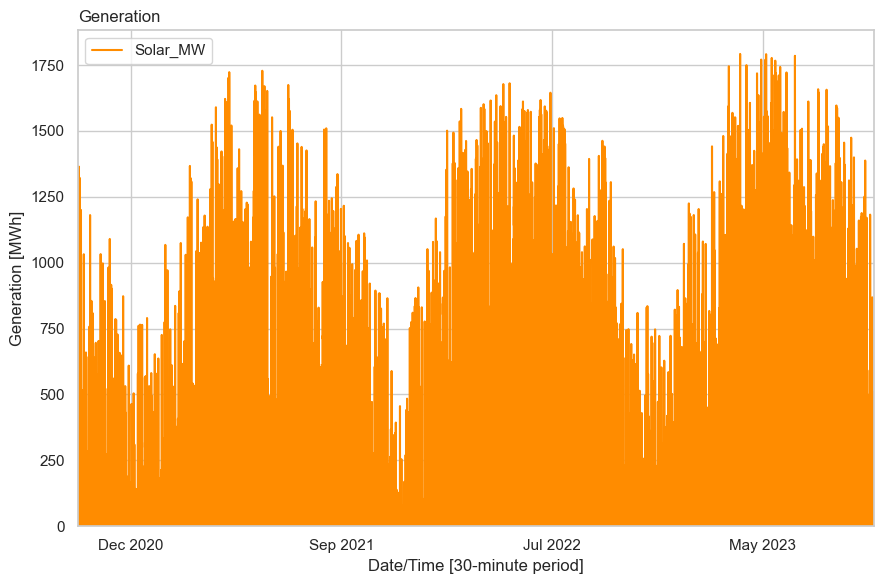

In [80]:
plt.figure(figsize=(9,6))
sns.set(style='whitegrid')
sns.color_palette("pastel", as_cmap=True)
ax1 = sns.lineplot(data=data_energy, x="dtm", y="Solar_MW",
                   label='Solar_MW', color="darkorange")
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax1.xaxis.set_major_locator(MaxNLocator(nbins=4))
ax1.set_xlim(left=data_energy['dtm'].min(), right=data_energy['dtm'].max())
ax1.set_ylim(0)
plt.title("Generation", loc='left')
plt.xlabel("Date/Time [30-minute period]")
plt.ylabel("Generation [MWh]")
ax1.legend(loc='best')
plt.tight_layout()

Text(0, 0.5, 'Generation [MW]')

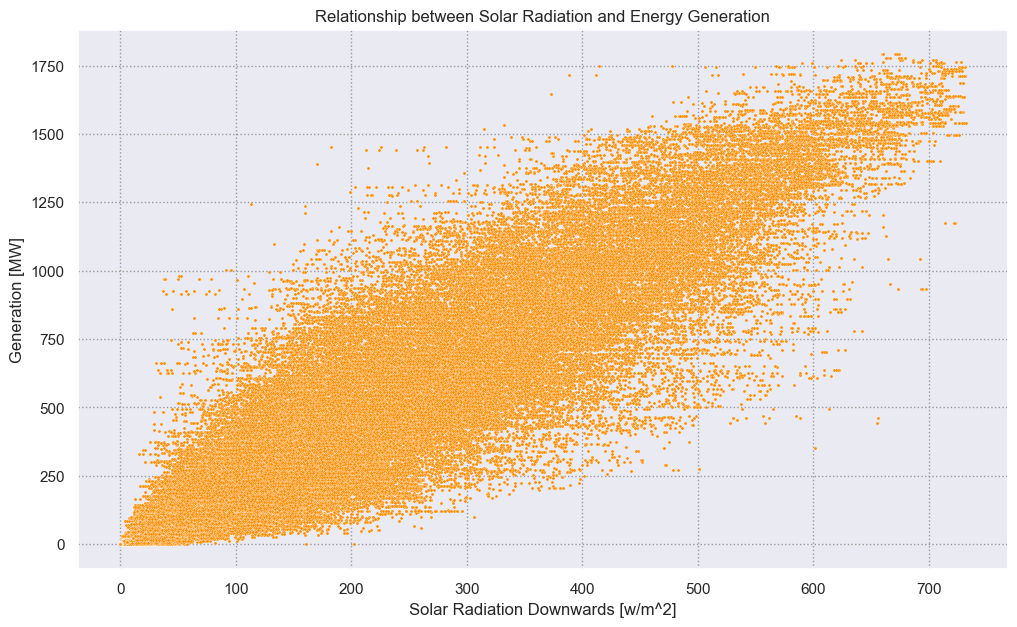

In [81]:
plt.figure(figsize=(12, 7))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=modelling_table, x="SolarDownwardRadiation", 
                y="Solar_MW", color='darkorange',s=5)
plt.title('Relationship between Solar Radiation and Energy Generation')
plt.xlabel('Solar Radiation Downwards [w/m^2]')
plt.ylabel('Generation [MW]')

# Training
We will use in order to evaluated the model performance Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE), Mean Squared Error (MSE) and R² Score, :


We train several models and observe their results based on the performances. 

In [82]:
# Train Linear Regression
model = LinearRegression()
model.fit(X_train_Selected, y_train)

y_pred = model.predict(X_test_Selected)

rmse = mean_squared_error(y_test, y_pred,squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE :", rmse)
print("MAPE :", mape)
print("MSE :", mse)
print("R² :", r2)

#Save the LR model using pickle
with open("models/LR_model.pkl", "wb") as file:
    pkl.dump(model, file)

RMSE : 0.34660726571385836
MAPE : 0.9610984903301785
MSE : 0.1201365966456372
R² : 0.8805293392746294


This need a certain parameter to work: We have tested CloudCover ~ SolarDownwardRadiation and Temperature ~ SolarDownwardRadiation but it seems to be not the optimal parameters

In [83]:
# # Train OLS regression model
# ols_model = smf.ols('CloudCover ~ SolarDownwardRadiation', data=X_train).fit()
# ols_pred = ols_model.predict(X_train_Selected)

# olsrmse = mean_squared_error(y_test, ols_pred,squared=False)
# olsmape = mean_absolute_percentage_error(y_test, ols_pred)
# olsmse = mean_squared_error(y_test, ols_pred)
# olsr2 = r2_score(y_test, ols_pred)

# print("RMSE :", olsrmse)
# print("MAPE :", olsmape)
# print("MSE :", olsmse)
# print("R² :", olsr2)

# #Save the OLS model using pickle
# with open("models/LR_model.pkl", "wb") as file:
#     pkl.dump(ols_model, file)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\theta\.conda\envs\HEFTcom24\Lib\site-packages\patsy\compat.py", line 36, in call_and_wrap_exc
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\theta\.conda\envs\HEFTcom24\Lib\site-packages\patsy\eval.py", line 169, in eval
    return eval(code, {}, VarLookupDict([inner_namespace]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<string>", line 1, in <module>
  File "C:\Users\theta\.conda\envs\HEFTcom24\Lib\site-packages\patsy\eval.py", line 52, in __getitem__
    return d[key]
           ~^^^^^
  File "C:\Users\theta\.conda\envs\HEFTcom24\Lib\site-packages\patsy\eval.py", line 52, in __getitem__
    return d[key]
           ~^^^^^
IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\theta\.cond

It can take some time to run it due to the high depth and the number of estimators

In [84]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(bootstrap = True, max_depth = 20, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 300)
rf_model.fit(X_train_Selected, y_train)
rfPred = rf_model.predict(X_test_Selected)

rfrmse = mean_squared_error(y_test, rfPred,squared=False)
rfmape = mean_absolute_percentage_error(y_test, rfPred)
rfmse = mean_squared_error(y_test, rfPred)
rfr2 = r2_score(y_test, rfPred)

print("RMSE :", rfrmse)
print("MAPE :", rfmape)
print("MSE :", rfmse)
print("R² :", rfr2)

# Save the Random Forest model
with open("models/rf_model.pkl", "wb") as file:
    pkl.dump(rf_model, file)

RMSE : 0.24238955964732017
MAPE : 0.6435341445179058
MSE : 0.05875269862602178
R² : 0.9415729767594986


In [85]:
# Train MLP Regressor with scaled data and increased iterations
mlp_model = MLPRegressor(solver='adam', alpha=1e-5, hidden_layer_sizes=(10, 5), max_iter=1000, learning_rate_init=0.001, random_state=0)
mlp_model.fit(X_train_Selected, y_train)
mlp_pred = mlp_model.predict(X_test_Selected)

mlprmse = mean_squared_error(y_test, mlp_pred,squared=False)
mlpmape = mean_absolute_percentage_error(y_test, mlp_pred)
mlpmse = mean_squared_error(y_test, mlp_pred)
mlpr2 = r2_score(y_test, mlp_pred)

print("RMSE :", mlprmse)
print("MAPE :", mlpmape)
print("MSE :", mlpmse)
print("R² :", mlpr2)

# Save the MLP model
with open("models/mlp_model.pkl", "wb") as file:
    pkl.dump(mlp_model, file)

RMSE : 0.32572918508109294
MAPE : 0.9289035819378177
MSE : 0.10609950201359289
R² : 0.8944886240985664


After the trainning of our different model, we can see that the Random Forest is the best model.

# Prediction

After the trainning of each model, we will have to compute the prediction. We need to clean and preprocess the dataset for the prediction. We need to make the same steps as the trainning part. 

# Loading the files

We load the energy file, the EU demand and the PES files. Each files need to be starting from 2023-10-28. And we need to select to the latest common date among all the file which is 2024-01-18.

In [86]:
#Loading the files
dwd_demand_1= xr.open_dataset("dwd_icon_eu_demand_20231027_20240108.nc")
dwd_demand_2 = xr.open_dataset("dwd_icon_eu_demand_20240108_20240129.nc")
dwd_demand = xr.merge([dwd_demand_1,dwd_demand_2], join="outer")
dwd_demand = dwd_demand.rename({'reference_time': 'ref_datetime'})
dwd_demand = dwd_demand.rename({'valid_time': 'valid_datetime'})
dwd_sort = dwd_demand.sortby('ref_datetime')

# Convert timestamp in numpy.datetime64
date_limit = np.datetime64('2024-01-18')
date_start = np.datetime64('2023-10-28')

# Select data until date limit 
dwd_demand = dwd_sort.sel(ref_datetime=slice(date_start, date_limit ))
dwd_demand_features1 = dwd_demand["RelativeHumidity"].mean(dim="point").to_dataframe().reset_index()
dwd_demand_features2 = dwd_demand["TotalPrecipitation"].mean(dim="point").to_dataframe().reset_index()

dwd_demand_features = dwd_demand_features1.merge(dwd_demand_features2,how="outer",on=["ref_datetime","valid_datetime"])

#Convert valid_datetime in datetime 
dwd_demand_features["ref_datetime"]=dwd_demand_features["ref_datetime"].dt.tz_localize("UTC")
dwd_demand_features["valid_datetime"] = dwd_demand_features["ref_datetime"] + pd.TimedeltaIndex(dwd_demand_features["valid_datetime"],unit="hours")

In [87]:
#Loading the files
dwd2024_1 = xr.open_dataset("dwd_icon_eu_pes10_20240108_20240129.nc")
dwd2024_2 = xr.open_dataset("dwd_icon_eu_pes10_20231027_20240108.nc")
dwd2024 = xr.merge([dwd2024_1, dwd2024_2], join='outer')
dwd2024 = dwd2024.rename({'reference_time': 'ref_datetime'})
dwd2024 = dwd2024.rename({'valid_time': 'valid_datetime'})
dws_sort = dwd2024.sortby('ref_datetime')

# Convert timestamp in numpy.datetime64
date_limit = np.datetime64('2024-01-18')
date_start = np.datetime64('2023-10-28')

# Select data until date limit 
dwd2024 = dws_sort.sel(ref_datetime=slice(date_start, date_limit ))
dwd2024_features1 = dwd2024["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()
dwd2024_features2 = dwd2024["CloudCover"].mean(dim="point").to_dataframe().reset_index()
dwd2024_features3 = dwd2024["Temperature"].mean(dim="point").to_dataframe().reset_index()

dwd2024_featuresInter = dwd2024_features1.merge(dwd2024_features2,how="outer",on=["ref_datetime","valid_datetime"])
dwd2024_features = dwd2024_featuresInter.merge(dwd2024_features3,how="outer",on=["ref_datetime","valid_datetime"])

dwd2024_features["ref_datetime"]=dwd2024_features["ref_datetime"].dt.tz_localize("UTC")
dwd2024_features["valid_datetime"] = dwd2024_features["ref_datetime"] + pd.TimedeltaIndex(dwd2024_features["valid_datetime"],unit="hours")

In [89]:
#Merge the data
dwd_merged = dwd2024_features.merge(dwd2024_features,how="outer",on=["ref_datetime","valid_datetime"])

In [90]:
#Loading the files
energy_data2024 = pd.read_csv("Energy_Data_20200920_20240118.csv")
energy_data2024['dtm'] = pd.to_datetime(energy_data2024['dtm'], utc=True)
energy_data2024['dtm'] = pd.to_datetime(energy_data2024['dtm'])

# Define limit and starting date
date_limit = pd.Timestamp('2024-01-18', tz='UTC')
date_start = pd.Timestamp('2023-10-28', tz='UTC')

# Data between the limit and starting date
energy_data2024 = energy_data2024[(energy_data2024['dtm'] >= date_start) & (energy_data2024['dtm'] <= date_limit)]
modeling_table = dwd_merged
modeling_table = modeling_table.set_index("valid_datetime").groupby("ref_datetime").resample("30min").ffill()
modeling_table = modeling_table.drop(columns="ref_datetime",axis=1).reset_index()
modeling_table = dwd_merged.merge(energy_data2024,how="inner",left_on="valid_datetime",right_on="dtm")
modeling_table = modeling_table[modeling_table["valid_datetime"] - modeling_table["ref_datetime"] < np.timedelta64(50,"h")]

In [91]:
modeling_table

,ref_datetime,valid_datetime,SolarDownwardRadiation_x,CloudCover_x,Temperature_x,SolarDownwardRadiation_y,CloudCover_y,Temperature_y,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price
0,2023-10-28 00:00:00+00:00,2023-10-28 00:00:00+00:00,0.000000,0.767782,8.909637,0.000000,0.767782,8.909637,2023-10-28 00:00:00+00:00,102.70,0.0,2453.093454,2609.200511,39.364,133.00,0.0,58.27
1,2023-10-28 00:00:00+00:00,2023-10-28 01:00:00+00:00,0.000000,0.825395,8.849225,0.000000,0.825395,8.849225,2023-10-28 01:00:00+00:00,71.73,0.0,2453.093454,2609.200511,72.764,0.00,0.0,51.71
2,2023-10-28 00:00:00+00:00,2023-10-28 02:00:00+00:00,0.000000,0.855148,8.893695,0.000000,0.855148,8.893695,2023-10-28 02:00:00+00:00,71.15,0.0,2453.093454,2609.200511,82.282,-5.00,0.0,48.30
3,2023-10-28 00:00:00+00:00,2023-10-28 03:00:00+00:00,0.000000,0.888122,8.987432,0.000000,0.888122,8.987432,2023-10-28 03:00:00+00:00,68.78,0.0,2453.093454,2609.200511,126.144,128.00,0.0,50.41
4,2023-10-28 00:00:00+00:00,2023-10-28 04:00:00+00:00,0.000000,0.950072,9.167096,0.000000,0.950072,9.167096,2023-10-28 04:00:00+00:00,74.51,0.0,2453.093454,2609.200511,75.184,133.00,0.0,65.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29808,2024-01-16 18:00:00+00:00,2024-01-17 23:00:00+00:00,-0.002539,0.055090,-2.450177,-0.002539,0.055090,-2.450177,2024-01-17 23:00:00+00:00,67.92,0.0,2448.464405,2609.200511,417.340,57.31,0.0,66.93
29809,2024-01-17 00:00:00+00:00,2024-01-17 23:00:00+00:00,-0.007031,0.065630,-1.940790,-0.007031,0.065630,-1.940790,2024-01-17 23:00:00+00:00,67.92,0.0,2448.464405,2609.200511,417.340,57.31,0.0,66.93
29810,2024-01-17 06:00:00+00:00,2024-01-17 23:00:00+00:00,0.009375,0.078533,-1.849188,0.009375,0.078533,-1.849188,2024-01-17 23:00:00+00:00,67.92,0.0,2448.464405,2609.200511,417.340,57.31,0.0,66.93
29811,2024-01-17 12:00:00+00:00,2024-01-17 23:00:00+00:00,0.003320,0.081824,-1.975024,0.003320,0.081824,-1.975024,2024-01-17 23:00:00+00:00,67.92,0.0,2448.464405,2609.200511,417.340,57.31,0.0,66.93


# Cleaning data

We delete the wrong values

In [92]:
#Data cleaning suppressing all the negative values
dataBrut = modelling_table
dataBrut = dataBrut[(dataBrut['boa_MWh'] >= 0) & (dataBrut['TotalPrecipitation'] >= 0) & (dataBrut['SolarDownwardRadiation'] >= 0)]
neg_SDR = (dataBrut['SolarDownwardRadiation'] < 0).sum()
neg_boa_MWh = (dataBrut['boa_MWh'] < 0).sum()

print(f"Valeurs négatives dans 'SolarDownwardRadiation': {neg_SDR}")
print(f"Valeurs négatives dans 'boa_MWh': {neg_boa_MWh}")

Valeurs négatives dans 'SolarDownwardRadiation': 0
Valeurs négatives dans 'boa_MWh': 0


In [93]:
seuil = 3
scores = np.abs(stats.zscore(dataBrut.select_dtypes(include=np.number)))
outlierRows = np.any(scores > seuil, axis=1)

In [94]:
dataNet = dataBrut[~outlierRows]
dataNet = dataNet.copy()
dataNet

,ref_datetime,valid_datetime,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price
1,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,91.974014,0.000000,0.000000,0.494018,13.670843,2020-09-20 01:00:00+00:00,28.68,0.0,2108.489754,2206.064655,941.044,47.95,0.0,32.00
2,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,92.541222,0.000000,0.000000,0.546410,13.793360,2020-09-20 02:00:00+00:00,28.19,0.0,2108.489754,2206.064655,918.432,28.95,0.0,31.99
3,2020-09-20 00:00:00+00:00,2020-09-20 03:00:00+00:00,93.603523,0.000000,0.000000,0.627071,13.907354,2020-09-20 03:00:00+00:00,28.50,0.0,2108.489754,2206.064655,978.682,30.90,0.0,32.54
4,2020-09-20 00:00:00+00:00,2020-09-20 04:00:00+00:00,94.086113,0.000000,0.000000,0.681062,14.022113,2020-09-20 04:00:00+00:00,24.00,0.0,2108.489754,2206.064655,1002.902,29.00,0.0,32.28
5,2020-09-20 00:00:00+00:00,2020-09-20 05:00:00+00:00,93.136665,0.000000,1.560938,0.702958,14.118970,2020-09-20 05:00:00+00:00,35.89,0.0,2108.489754,2206.064655,990.988,28.62,0.0,32.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414947,2023-10-26 00:00:00+00:00,2023-10-27 22:00:00+00:00,95.594032,0.002232,0.009360,0.445369,8.483948,2023-10-27 22:00:00+00:00,NaN,0.0,2331.383994,2487.180474,132.522,129.00,0.0,64.31
414950,2023-10-26 18:00:00+00:00,2023-10-27 22:00:00+00:00,95.839966,0.000558,0.000540,0.474188,8.563037,2023-10-27 22:00:00+00:00,NaN,0.0,2331.383994,2487.180474,132.522,129.00,0.0,64.31
414958,2023-10-26 06:00:00+00:00,2023-10-27 23:00:00+00:00,96.149948,0.007254,0.011918,0.702725,8.493952,2023-10-27 23:00:00+00:00,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68
414959,2023-10-26 12:00:00+00:00,2023-10-27 23:00:00+00:00,96.074356,0.008929,0.013232,0.771242,8.299957,2023-10-27 23:00:00+00:00,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68


# Imputation

In [95]:
#Imputation of the date/timestamp
dataNet['dtm'] = pd.to_datetime(dataNet['dtm'],utc=True)
dataNet['year'] = dataNet['dtm'].dt.year
dataNet['month'] = dataNet['dtm'].dt.month
dataNet['day'] = dataNet['dtm'].dt.day
dataNet['hour'] = dataNet['dtm'].dt.hour
dataNet['minute'] = dataNet['dtm'].dt.minute
dataNet['second'] = dataNet['dtm'].dt.second

We assemble the missing value to similar group of data

In [96]:
timeFeatures = ['dtm','ref_datetime','valid_datetime']
DataTime = dataNet.drop(timeFeatures, axis=1).copy()
DataImp = KNN(DataTime)

In [97]:
#Creation of new features seen before
DataImp['log_CloudCover'] = np.log(DataImp['CloudCover'])
DataImp['log_RelativeHumidity'] = np.log(DataImp['RelativeHumidity'])

DataImp['log_SolarDownwardRadiation'] = np.log(DataImp['SolarDownwardRadiation'])
DataImp['log_TotalPrecipitation'] = np.log(DataImp['TotalPrecipitation'])
DataImp['cube_root_MIP'] = np.cbrt(DataImp['MIP'])
DataImp['cube_root_SS_Price'] = np.cbrt(DataImp['SS_Price'])
DataImp['cube_root_DA_Price'] = np.cbrt(DataImp['DA_Price'])
DataImp['log_Solar_capacity_mwp'] = np.log(DataImp['Solar_capacity_mwp'])

DataImp['Radiation_x_Cloud Cover'] = DataImp['SolarDownwardRadiation'] * DataImp['CloudCover']
DataImp['Temperature x Radiation'] = DataImp['Temperature'] * DataImp['SolarDownwardRadiation'] 
DataImp['Wind x Radiation'] = DFI['Wind_MW'] * DataImp['SolarDownwardRadiation'] 

C:\Users\theta\.conda\envs\HEFTcom24\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\theta\.conda\envs\HEFTcom24\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\theta\.conda\envs\HEFTcom24\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [98]:
#Visualization
DataImp

,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,...,log_RelativeHumidity,log_SolarDownwardRadiation,log_TotalPrecipitation,cube_root_MIP,cube_root_SS_Price,cube_root_DA_Price,log_Solar_capacity_mwp,Radiation_x_Cloud Cover,Temperature x Radiation,Wind x Radiation
0,91.974014,0.000000,0.000000,0.494018,13.670843,28.68,0.0,2108.489754,2206.064655,941.044,...,4.521506,-inf,-inf,3.060975,3.632979,3.174802,7.653727,0.000000,0.000000,0.000000
1,92.541222,0.000000,0.000000,0.546410,13.793360,28.19,0.0,2108.489754,2206.064655,918.432,...,4.527654,-inf,-inf,3.043442,3.070550,3.174471,7.653727,0.000000,0.000000,0.000000
2,93.603523,0.000000,0.000000,0.627071,13.907354,28.50,0.0,2108.489754,2206.064655,978.682,...,4.539068,-inf,-inf,3.054557,3.137999,3.192561,7.653727,0.000000,0.000000,0.000000
3,94.086113,0.000000,0.000000,0.681062,14.022113,24.00,0.0,2108.489754,2206.064655,1002.902,...,4.544210,-inf,-inf,2.884499,3.072317,3.184035,7.653727,0.000000,0.000000,0.000000
4,93.136665,0.000000,1.560938,0.702958,14.118970,35.89,0.0,2108.489754,2206.064655,990.988,...,4.534068,0.445287,-inf,3.298561,3.058838,3.200716,7.653727,1.097273,22.038830,1.582596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162478,95.594032,0.002232,0.009360,0.445369,8.483948,97.16,0.0,2331.383994,2487.180474,132.522,...,4.560110,-4.671338,-6.104793,4.597226,5.052774,4.006448,7.754217,0.004169,0.079408,-0.009015
162479,95.839966,0.000558,0.000540,0.474188,8.563037,97.16,0.0,2331.383994,2487.180474,132.522,...,4.562680,-7.523643,-7.491088,4.597226,5.052774,4.006448,7.754217,0.000256,0.004625,-0.000520
162480,96.149948,0.007254,0.011918,0.702725,8.493952,86.84,0.0,2331.383994,2487.180474,28.662,...,4.565909,-4.429716,-4.926138,4.428330,5.104469,3.885945,7.754217,0.008375,0.101230,-0.014329
162481,96.074356,0.008929,0.013232,0.771242,8.299957,86.84,0.0,2331.383994,2487.180474,28.662,...,4.565122,-4.325143,-4.718499,4.428330,5.104469,3.885945,7.754217,0.010205,0.109822,-0.015908


In [99]:
scalerStand = StandardScaler()
numeric_cols = DataImp.select_dtypes(include=np.number).columns
df = DataImp
df = df.replace([np.inf, -np.inf], 0)
df = df.replace(np.nan, 0)
df[numeric_cols] = scalerStand.fit_transform(df[numeric_cols])
df

,RelativeHumidity,TotalPrecipitation,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,...,log_RelativeHumidity,log_SolarDownwardRadiation,log_TotalPrecipitation,cube_root_MIP,cube_root_SS_Price,cube_root_DA_Price,log_Solar_capacity_mwp,Radiation_x_Cloud Cover,Temperature x Radiation,Wind x Radiation
0,1.103658,-0.546840,-0.796656,-0.825454,0.392109,-1.209842,-0.740502,-0.866757,-1.015572,0.898858,...,1.014503,-0.393916,0.974188,-1.376429,-0.577976,-1.555478,-0.877829,-0.764069,-0.654080,0.147047
1,1.148806,-0.546840,-0.796656,-0.639244,0.412362,-1.216077,-0.740502,-0.866757,-1.015572,0.846784,...,1.049568,-0.393916,0.974188,-1.390867,-0.921238,-1.555789,-0.877829,-0.764069,-0.654080,0.147047
2,1.233362,-0.546840,-0.796656,-0.352564,0.431207,-1.212132,-0.740502,-0.866757,-1.015572,0.985536,...,1.114665,-0.393916,0.974188,-1.381713,-0.880073,-1.538740,-0.877829,-0.764069,-0.654080,0.147047
3,1.271774,-0.546840,-0.796656,-0.160675,0.450178,-1.269393,-0.740502,-0.866757,-1.015572,1.041313,...,1.143994,-0.393916,0.974188,-1.521754,-0.920160,-1.546776,-0.877829,-0.764069,-0.654080,0.147047
4,1.196201,-0.546840,-0.786998,-0.082852,0.466190,-1.118098,-0.740502,-0.866757,-1.015572,1.013876,...,1.086148,-0.293223,0.974188,-1.180779,-0.928386,-1.531054,-0.877829,-0.754729,-0.646487,0.155127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162478,1.391800,-0.529469,-0.796598,-0.998357,-0.465351,-0.338466,-0.740502,1.779347,1.802903,-0.963120,...,1.234676,-1.450245,-1.088942,-0.111344,0.288555,-0.771660,1.770201,-0.764034,-0.654053,0.147001
162479,1.411375,-0.542497,-0.796653,-0.895929,-0.452276,-0.338466,-0.740502,1.779347,1.802903,-0.963120,...,1.249330,-2.095236,-1.557444,-0.111344,0.288555,-0.771660,1.770201,-0.764067,-0.654078,0.147044
162480,1.436049,-0.490385,-0.796582,-0.083682,-0.463697,-0.469783,-0.740502,1.779347,1.802903,-1.202303,...,1.267747,-1.395607,-0.690613,-0.250428,0.320105,-0.885232,1.770201,-0.763998,-0.654045,0.146974
162481,1.430032,-0.477357,-0.796574,0.159839,-0.495767,-0.469783,-0.740502,1.779347,1.802903,-1.202303,...,1.263262,-1.371960,-0.620441,-0.250428,0.320105,-0.885232,1.770201,-0.763983,-0.654042,0.146965


In [100]:
feat = df.drop(['Solar_MW'], axis = 1)
y_test = df['Solar_MW']

In [101]:
col = ['RelativeHumidity', 'SolarDownwardRadiation', 'Temperature', 'Wind_MW',
       'year', 'log_RelativeHumidity', 'log_SolarDownwardRadiation',
       'Radiation_x_Cloud Cover', 'Temperature x Radiation',
       'Wind x Radiation']
feat = feat[col].copy()

In [102]:
feat

,RelativeHumidity,SolarDownwardRadiation,Temperature,Wind_MW,year,log_RelativeHumidity,log_SolarDownwardRadiation,Radiation_x_Cloud Cover,Temperature x Radiation,Wind x Radiation
0,1.103658,-0.796656,0.392109,0.898858,-1.870993,1.014503,-0.393916,-0.764069,-0.654080,0.147047
1,1.148806,-0.796656,0.412362,0.846784,-1.870993,1.049568,-0.393916,-0.764069,-0.654080,0.147047
2,1.233362,-0.796656,0.431207,0.985536,-1.870993,1.114665,-0.393916,-0.764069,-0.654080,0.147047
3,1.271774,-0.796656,0.450178,1.041313,-1.870993,1.143994,-0.393916,-0.764069,-0.654080,0.147047
4,1.196201,-0.786998,0.466190,1.013876,-1.870993,1.086148,-0.293223,-0.754729,-0.646487,0.155127
...,...,...,...,...,...,...,...,...,...,...
162478,1.391800,-0.796598,-0.465351,-0.963120,1.293447,1.234676,-1.450245,-0.764034,-0.654053,0.147001
162479,1.411375,-0.796653,-0.452276,-0.963120,1.293447,1.249330,-2.095236,-0.764067,-0.654078,0.147044
162480,1.436049,-0.796582,-0.463697,-1.202303,1.293447,1.267747,-1.395607,-0.763998,-0.654045,0.146974
162481,1.430032,-0.796574,-0.495767,-1.202303,1.293447,1.263262,-1.371960,-0.763983,-0.654042,0.146965


# Model of prediction

We load the diffent models that we have trained and do the prediction on the test set

- RMSE: The lower the better.
- MAPE: The lower the better.
- MSE: The lower the better.
- R²: The higher the better.

## MLP

In [104]:
#MLP Prediction
with open("models/mlp_model.pkl", "wb") as file:
    pkl.dump(mlp_model, file)

mlp_pred = mlp_model.predict(feat)

mlp_rmse= mean_squared_error(y_test, mlp_pred, squared=False)
mlp_mape = mean_absolute_percentage_error(y_test, mlp_pred)
mlp_mse = mean_squared_error(y_test, mlp_pred)
mlp_mse = r2_score(y_test, mlp_pred)


print("RMSE :", mlp_rmse)
print("MAPE :", mlp_mape)
print("MSE :", mlp_mse)
print("R² :", mlp_mse)

RMSE : 0.46732958563046023
MAPE : 1.4178447538971248
MSE : 0.7816030583944623
R² : 0.7816030583944623


C:\Users\theta\.conda\envs\HEFTcom24\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


## Random Forest

In [105]:
#Random Forest Prediction
with open("models/rf_model.pkl", "wb") as file:
    pkl.dump(rf_model, file)

rf_pred = rf_model.predict(feat)

rf_rmse = mean_squared_error(y_test, rf_pred, squared=False)
rf_mape = mean_absolute_percentage_error(y_test, rf_pred)
rf_rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print("RMSE :", rf_rmse)
print("MAPE :", rf_mape)
print("MSE :", rf_rf_mse)
print("R² :", rf_r2)

C:\Users\theta\.conda\envs\HEFTcom24\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


RMSE : 0.3228406840463453
MAPE : 1.5492919080212604
MSE : 0.10422610727551214
R² : 0.8957738927244878


## Linear Regression

In [106]:
#Linear Regression Prediction
with open("models/LR_model.pkl", "wb") as file:
    pkl.dump(model, file)

lr_pred = model.predict(feat)

lr_rmse= mean_squared_error(y_test, lr_pred, squared=False)
lr_mape = mean_absolute_percentage_error(y_test, lr_pred)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

print("RMSE :", lr_rmse)
print("MAPE :", lr_mape)
print("MSE :", lr_mse)
print("R² :", lr_r2)

RMSE : 0.34657895504987124
MAPE : 1.093762312960718
MSE : 0.12011697208346069
R² : 0.8798830279165393


C:\Users\theta\.conda\envs\HEFTcom24\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


# Comparison

Random Forest (RF) outperforms in RMSE, MSE, and R², suggesting it captures the relationship between features and the target variable well but may be overfitting given the higher MAPE.
<br> Linear Regression (LR), with the lowest MAPE, indicates it makes fewer percentage errors and might generalize better on new data due to its simplicity.
<br> Multi-Layer Perceptron (MLP) shows the least favorable performance across most metrics.
Summary
<br> While RF shows superior performance in RMSE, MSE, and R², LR's lower MAPE highlights its robustness and generalizability, indicating a primarily linear relationship between features and the target variable. Thus, despite RF's higher complexity, LR's simpler model may offer more consistent performance across varied datasets.

# Conclusion

Based on RMSE, MSE, and R², the Random Forest model is the best performer among the three models. The Linear Regression model has the lowest MAPE, but it is not as critical as the other metrics in this context. Therefore, the Random Forest model would be considered the best overall model for this problem.

# Dashboard

In [110]:
#Dashboard
import pandas as pd
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go

# Load CSV files
energy_data_1 = pd.read_csv('Energy_Data_20200920_20231027.csv')
energy_data_2 = pd.read_csv('Energy_Data_20200920_20240118.csv')
predictions = pd.read_csv('predictions.csv')

# Merge energy data into a single DataFrame
energy_data = pd.concat([energy_data_1, energy_data_2]).drop_duplicates().reset_index(drop=True)

# Convert date columns to datetime
energy_data['dtm'] = pd.to_datetime(energy_data['dtm'])
predictions['date'] = pd.to_datetime(predictions['date'])

# Merge predictions with actual energy data
merged_data = pd.merge(predictions, energy_data, left_on='date', right_on='dtm')

# Create Dash application
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Energy Predictions Dashboard"),
    dcc.Graph(id='time-series-chart'),
    dcc.Checklist(
        id='model-selection',
        options=[
            {'label': 'OLS Predicted', 'value': 'OLS_Predicted'},
            {'label': 'RF Predicted', 'value': 'RF_Predicted'},
            {'label': 'MLP Predicted', 'value': 'MLP_Predicted'}
        ],
        value=['OLS_Predicted', 'RF_Predicted', 'MLP_Predicted'],
        labelStyle={'display': 'inline-block'}
    ),
])

@app.callback(
    Output('time-series-chart', 'figure'),
    [Input('model-selection', 'value')]
)
def update_graph(selected_models):
    traces = []
    traces.append(go.Scatter(
        x=merged_data['date'],
        y=merged_data['actual'],
        mode='lines',
        name='Actual'
    ))
    for model in selected_models:
        traces.append(go.Scatter(
            x=merged_data['date'],
            y=merged_data[model],
            mode='lines',
            name=model
        ))
    
    layout = go.Layout(
        title='Actual vs Predicted Energy Values',
        xaxis={'title': 'Date'},
        yaxis={'title': 'Energy (MW)'}
    )
    return {'data': traces, 'layout': layout}
    
if __name__ == '__main__':
    app.run_server(debug=True, host='127.0.0.1', port=8051)
